## K-means to find similar Airbnb listings in NYC
The objective of K-means is simply to group *similar* data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset. A cluster refers to a collection of data points aggregated together because of certain similarities. You’ll define a target number k, which refers to the number of centroids you need in the dataset. This is how the algorithm works:
- It starts by selecting randomly allocated centriods, which are used as the beginning points of every cluster, and then performs iterative calculations to optimize the position of the centriods.
- This process continues until: 
    - The centroids have stabilized — there is no change in their values because the clustering has been successful.
    - The defined number of iterations has been achieved.

For accurate clustering results K-means expects the data to adhere to the following assumptions:
- Equal average values of variables
- Equal standard deviation of variables
- Symmetrical distribution of variables

It is our duty to ensure that these assumptions have been met during the pre-processing stage. We tackled these assumptions in the data pre-processing stage, so we are good to continue with our clustering task. 

The last thing we need before we get the clusters is to choose the number of clusters. The next section deals with methods for choosing the right number of clusters for our dataset.

## Deciding on the K-value
There are several methods for deciding the correct k-value:
- Visual Methods: elbow criteria
- Mathematical methods: silhouette coefficient
- Experimentation and interpretation

We will be using the elbow method to decide the value of K to use. The **elbow criterion method, plots the number of clusters against within-cluster sum-of-squared-errors (SSE)** - *which is the sum of squared distances from every data point to their cluster center.*  We then look at the chart to find where the decrease in SSE slows down and becomes somewhat marginal, that point looks like an elbow and suggests the point of diminishing returns by increasing the number of clusters. This point represents the optimal number of clusters from a sum-of-squared-errors perspective. However, we should choose several options around the elbow to test what makes the most sense. 

## Get the data
Let's begin our analysis by taking the output dataset of the PCA analysis, check here for the steps used to construct this dataset: [NYC Airbnb PCA analysis](https://shravan-kuchkula.github.io/nyc-airbnb-pca/#save-and-upload-to-s3)

In [2]:
# import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# get the data
data = pd.read_csv('../data/raw/airbnb_final.csv')
data.head()

,price_category,name,id,price,adjusted_price,minimum_nights,bedrooms,bathrooms,neighbourhood_group_cleansed,neighbourhood_cleansed,...,40,41,42,43,44,45,46,47,48,49
0,high,Skylit Midtown Castle,2595,225.0,225.000000,1,0.0,1.0,Manhattan,Midtown,...,0.576904,0.466956,0.331311,0.261779,-0.330193,1.620287,0.867739,-0.798060,-0.576860,-0.254925
1,medium,THE VILLAGE OF HARLEM....NEW YORK !,3647,150.0,50.000000,3,1.0,1.0,Manhattan,Harlem,...,-0.252328,0.226731,0.269839,-0.211928,0.147831,1.354929,0.801862,-0.292820,-0.804985,-0.202175
2,low,Entire Apt: Spacious Studio/Loft by central park,5022,80.0,8.000000,10,1.0,1.0,Manhattan,East Harlem,...,0.193168,0.068044,0.015844,0.197295,-0.167786,1.117572,0.749340,0.109282,-0.870940,-0.278948
3,medium,Large Cozy 1 BR Apartment In Midtown East,5099,200.0,66.666667,3,1.0,1.0,Manhattan,Murray Hill,...,0.416250,-0.057388,0.073780,0.143102,0.198163,1.440193,0.641507,-0.021390,-0.912154,-0.285108
4,low,BlissArtsSpace!,5121,60.0,1.333333,45,1.0,1.0,Brooklyn,Bedford-Stuyvesant,...,-0.214280,-0.095810,0.224063,0.083689,-0.192449,0.410582,0.017357,0.246550,0.796558,0.307420


We are interested only in the Principal Components data, starting from 10th column

In [25]:
# gather all the PCA components
# rename the PC columns
pc_col_names = ["pc_" + item for item in list(data.columns[10:])]

# extract the 50 principal components
pc_data = data.iloc[:, 10:]

# rename the columns
pc_data.columns = pc_col_names

We are going to use the 50 principal components that we constructed in this post: [NYC Airbnb PCA](https://shravan-kuchkula.github.io/nyc-airbnb-pca/) .Displayed below is the shape and head of these components.

In [26]:
pc_data.shape

(45605, 50)

In [27]:
pc_data.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_40,pc_41,pc_42,pc_43,pc_44,pc_45,pc_46,pc_47,pc_48,pc_49
0,2.658552,-1.455526,0.699093,-0.553412,-0.125384,-0.654187,-0.044713,-0.001357,0.108582,1.333186,...,0.576904,0.466956,0.331311,0.261779,-0.330193,1.620287,0.867739,-0.798060,-0.576860,-0.254925
1,-1.644174,-0.715321,1.097099,0.893833,0.399013,-0.139751,-1.183842,-1.132572,0.996817,0.151908,...,-0.252328,0.226731,0.269839,-0.211928,0.147831,1.354929,0.801862,-0.292820,-0.804985,-0.202175
2,-1.012114,-1.718006,-0.320889,-0.356113,0.113797,0.392780,-0.399569,-0.819086,-0.133456,-0.200684,...,0.193168,0.068044,0.015844,0.197295,-0.167786,1.117572,0.749340,0.109282,-0.870940,-0.278948
3,0.067402,-0.520919,-0.263865,0.353879,-0.907122,-0.906052,-1.158888,-0.624668,-0.071571,0.780228,...,0.416250,-0.057388,0.073780,0.143102,0.198163,1.440193,0.641507,-0.021390,-0.912154,-0.285108
4,-1.666907,1.296202,0.520533,0.659033,1.262238,-0.516450,-0.827510,-0.678685,0.010626,0.180606,...,-0.214280,-0.095810,0.224063,0.083689,-0.192449,0.410582,0.017357,0.246550,0.796558,0.307420


### Fit K-means for K=1 to K=10 clusters and use Elbow Method

In [28]:
# Fit Kmeans and calculate SSE for each k value
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(pc_data)
    sse[k] = kmeans.inertia_ # sum of squared distances to the closest cluster centers

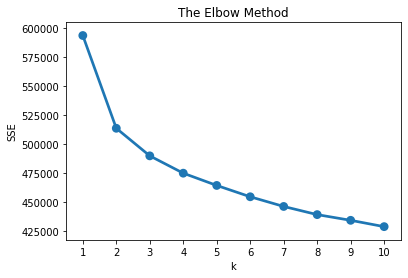

In [29]:
# plot SSE for each k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Using K=3
Looking at the above Elbow plot, we can see that for K-values of 2 and 3, there is a sharp decrease in SSE. I chose the value of K=3 instead of K=2, since I broke down the airbnb listings into 3 price categories: high, medium, low, and I want to see if K-means clustering picked out the listings by grouping them as per their price range.

In [30]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(pc_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [31]:
# get the labels
cluster_labels = kmeans.labels_

# assign these clusters back into the dataframe
pc_data_k3 = pc_data.assign(cluster=cluster_labels)

# display the shape
pc_data_k3.shape

(45605, 51)

In [32]:
pc_data_k3.cluster.value_counts()

2    16801
0    14767
1    14037
Name: cluster, dtype: int64

## Combine cluster labels with the main dataset for visualization

In [36]:
other_col_names = list(data.columns[:10])
other_col_names

['price_category',
 'name',
 'id',
 'price',
 'adjusted_price',
 'minimum_nights',
 'bedrooms',
 'bathrooms',
 'neighbourhood_group_cleansed',
 'neighbourhood_cleansed']

In [38]:
k_means_visual = data[other_col_names]
k_means_visual.shape

(45605, 10)

In [41]:
k_means_visual = k_means_visual.assign(cluster=cluster_labels)
k_means_visual.head()

,price_category,name,id,price,adjusted_price,minimum_nights,bedrooms,bathrooms,neighbourhood_group_cleansed,neighbourhood_cleansed,cluster
0,high,Skylit Midtown Castle,2595,225.0,225.000000,1,0.0,1.0,Manhattan,Midtown,1
1,medium,THE VILLAGE OF HARLEM....NEW YORK !,3647,150.0,50.000000,3,1.0,1.0,Manhattan,Harlem,2
2,low,Entire Apt: Spacious Studio/Loft by central park,5022,80.0,8.000000,10,1.0,1.0,Manhattan,East Harlem,2
3,medium,Large Cozy 1 BR Apartment In Midtown East,5099,200.0,66.666667,3,1.0,1.0,Manhattan,Murray Hill,2
4,low,BlissArtsSpace!,5121,60.0,1.333333,45,1.0,1.0,Brooklyn,Bedford-Stuyvesant,0


In [42]:
k_means_visual.shape

(45605, 11)

## Save and upload to S3

In [43]:
k_means_visual.to_csv('k_means_visual.csv', index=False)

In [45]:
import configparser
config = configparser.ConfigParser()
config.read_file(open('/Users/shravan/projects/interview-prep/credentials.cfg'))

KEY = config.get('AWS','KEY')
SECRET = config.get('AWS','SECRET')

In [46]:
import boto3

# Generate the boto3 client for interacting with S3
s3 = boto3.client('s3', region_name='us-east-1', 
                        # Set up AWS credentials 
                        aws_access_key_id=KEY, 
                        aws_secret_access_key=SECRET)

In [47]:
s3.upload_file(Bucket='skuchkula-sagemaker-airbnb',
              Filename='k_means_visual.csv',
              Key='feature/k_means_visual.csv')

## Visualize K-means clusters on a folium map
It is possible to visualize each of the airbnb listings on a map and color code them based on the cluster they are assigned. By using `geopandas` and `folium` we can project each of the listings onto the New York City map.

`folium` builds on the data wrangling strengths of the Python ecosystem and the mapping strengths of the leaflet.js library. Manipulate your data in Python, then visualize it in on a Leaflet map via folium. Read more about
[folium](https://python-visualization.github.io/folium/index.html)

In [4]:
import numpy as np
import os
import geopandas
import folium
%matplotlib inline

In order to visualize the data on a map, we need the latitude and longitude information for each listing. This is available from the data cleaning blog [NYC Airbnb Data Cleaning](https://shravan-kuchkula.github.io/nyc-airbnb-data-cleaning/#upload-the-cleaned-file-to-s3), where the **upload-the-cleaned-file-to-s3** section contains the dataset with the same rows **45605** which was obtained after filtering out some property types. Let's load that dataset in.

In [7]:
# read in the dataset
airbnb_clean = pd.read_csv('../data/raw/airbnb_clean.csv')
airbnb_clean.shape

(45605, 67)

In [15]:
# get only the latitude and longitude of each listing
airbnb_coord = airbnb_clean[['latitude', 'longitude']]

# concatenate the coordinates with k_means results 
k_means_map = pd.concat([k_means_visual, airbnb_coord], axis=1)

The `geojson` files encode the polygons representing a geographic entity. Example, a neighbourhood in NYC like Chelsea is represented as a polygon. To read in a **geojson** file, we will be using the `geopandas.read_file()`. 

In [17]:
# data directory
data_dir = "../data"
raw_data = os.path.join(data_dir, "raw")

# read in the data
nbhoods = geopandas.read_file(os.path.join(raw_data, "neighbourhoods.geojson"))
subway = geopandas.read_file(os.path.join(raw_data, "subway.geojson"))

Since the k-means results dataframe is just a pandas dataframe, our first task in working with geopandas is to convert our pandas dataframe into a geopandas dataframe. To do this, simply pass the longitude and latitude values to the `points_from_xy()` method and assign that to the *geometry* argument while constructing the `GeoDataFrame()`.

In [18]:
# construct a geodataframe
k_means_map_geo = geopandas.GeoDataFrame(k_means_map, geometry=geopandas.points_from_xy(k_means_map.longitude, 
                                                                            k_means_map.latitude))

The beauty of a geodataframe is that we can isolate a geographic location based on simple pandas dataframe like filtering. For example, if I wanted the polygon representing Chelsea, we can get that using:

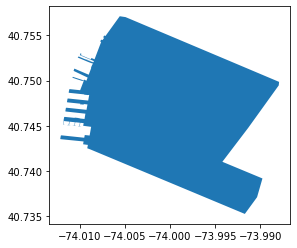

In [117]:
# get chelsea neighborhood
chelsea = nbhoods[nbhoods.neighbourhood == 'Chelsea'].geometry
ax=chelsea.plot()

Now that we have the polygon representing **Chelsea**, our next step is to get the co-ordinates of all the airbnb listings within chelsea. Again, since our dataframe is a geodataframe, we can simply use pandas filtering to isolate all the listings with this criteria: ***Get airbnb listings in Chelsea with 1 bedroom and which require minimum nights of 1 and that are below 150 dollars.*** . I've used this filtering to avoid over-crowding in my visualization.

In [96]:
# get chelsea airbnb listings co-ordinates and their assigned clusters
chelsea_listings = k_means_map_geo[(k_means_map_geo.neighbourhood_cleansed == 'Chelsea') & 
                (k_means_map_geo.bedrooms == 1) & (k_means_map_geo.minimum_nights == 1) & 
               (k_means_map_geo.price < 150)]

Finally, we are ready to use the `folium.Map` and project our listings onto this map. The folium Map constructor takes an initial starting co-ordinate to center the map on. I chose a random location close to the center of Chelsea neighborhood. 

Next, we iterate over the dataframe and use the row values to assign each cluster a unique color. We then specify a popup string to be displayed when the user clicks on the marker. 

The marker itself, takes the **location**, **popup** and **icon** - the icon color is based on the K-means cluster number associated with the listing. 

In [110]:
m = folium.Map(location=[40.74601, -73.99987], zoom_start=14.5)
folium.GeoJson(chelsea).add_to(m)

# Build markers and popups
for row in chelsea_listings.iterrows():
    row_values = row[1]
    center_point = row_values['geometry']
    location = [center_point.y, center_point.x]
    if row_values['cluster'] == 0:
        marker_color = 'lightred'
    elif row_values['cluster'] == 1:
        marker_color = 'cadetblue'
    else:
        marker_color = 'lightgreen'
    popup = ('NAME: ' + str(row_values['name']) + 
             '  ' + 'PRICE: $' + str(row_values['price']))
    marker = folium.Marker(location = location, popup = popup, icon=folium.Icon(color=marker_color, icon='home'))
    marker.add_to(m)

display(m)

## What can we gather from this visual?
Let's say you found an airbnb location that you liked: `"LISTING NAME: Room in a beautiful chelsea apt. w/doorman PRICE: 100` on **10th Avenue and West 20th Street** and you decide that it is too far from the nearest subway station. You wish to find ***similar*** listing somewhere close to **34th Street Penn Station** (which is a major hub across the tri-state region). By choosing another member of the same cluster closer to the penn station, you can trust that there is some similarity between these two locations. You can then, narrow down your search and find what you are looking for.

The word **similar** here has a much deeper meaning than just saying *similar price*, *similar amenities* etc. It is a combination of **2100 features** that we have created using NLP and Feature Engineering and then asked an unsupervised machine learning algorithm like K-Means to group them based on how close they are in terms of distance in the vector/component space.

Rather than browsing through hundereds of airbnb listings by reading their descriptions, checking their amenities, filtering by price, or asking your friend's opinion, you can easily find similar airbnb listings that meet your requirements using K-means clustering!  